In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from modules.Neural_Work_Library import nn as nnlib
from modules.Preprocess_Validation import preprocess
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import pandas as pd

Set Datasets

In [277]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_folder = nnlib.MemeOrCatDataSet(data_dir="../SaladWithPizza/train/", transform=transform)
valid_folder = nnlib.MemeOrCatDataSet(data_dir="../SaladWithPizza/valid/", transform=transform)

train_loader = DataLoader(train_folder, batch_size=64, shuffle=True, pin_memory=True, pin_memory_device="cuda:0")
valid_loader = DataLoader(valid_folder, batch_size=10, shuffle=False, pin_memory=True, pin_memory_device="cuda:0")

PreProssor = preprocess.PreProcess(transform)

Model/Device

In [376]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(device))

# create model instance
model = nnlib.MemeClassConv2d()
model.to(device, non_blocking=True)
model.total_epochs = 0

train_losses, val_losses = [], []

# loss Function
criterion = nn.CrossEntropyLoss()

NVIDIA GeForce RTX 4070 Ti


Training Cycle

In [377]:
num_epoch = 30

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

l2_lambda = 0.01 

for epoch in tqdm(range(num_epoch), desc="Training Model"):

    # Train cycle
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Optimizer / Backwards prop
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # L2 regularization
        loss += l2_lambda * sum(torch.sum(param ** 2) for param in model.parameters())

        loss.backward()
        optimizer.step()

        # Calculate train loss
        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation cycle
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            # Calculate Val loss
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
    val_loss = running_loss / len(valid_loader.dataset)
    val_losses.append(val_loss)

    # print EPOCH
    print(f"Epoch {epoch+1}/{num_epoch} - Train Loss {train_loss}, valid_loss {val_loss}")
    model.total_epochs += 1

Training Model:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss 1.4952683108193534, valid_loss 0.6932245492935181
Epoch 2/30 - Train Loss 1.2384086847305298, valid_loss 0.6934995949268341
Epoch 3/30 - Train Loss 1.1280416250228882, valid_loss 0.6935857236385345
Epoch 4/30 - Train Loss 1.088904653276716, valid_loss 0.6933547854423523
Epoch 5/30 - Train Loss 1.0748819623674666, valid_loss 0.6932940483093262
Epoch 6/30 - Train Loss 1.0560244151524134, valid_loss 0.6932180523872375
Epoch 7/30 - Train Loss 1.0246706690107072, valid_loss 0.6932843327522278
Epoch 8/30 - Train Loss 0.988405168056488, valid_loss 0.6932636499404907
Epoch 9/30 - Train Loss 0.9547283819743565, valid_loss 0.6932227611541748
Epoch 10/30 - Train Loss 0.9281896352767944, valid_loss 0.6932859420776367
Epoch 11/30 - Train Loss 0.9066994190216064, valid_loss 0.6931214034557343
Epoch 12/30 - Train Loss 0.8899047715323312, valid_loss 0.6930832266807556
Epoch 13/30 - Train Loss 0.8754131112779889, valid_loss 0.6930690407752991
Epoch 14/30 - Train Loss 0.859405815

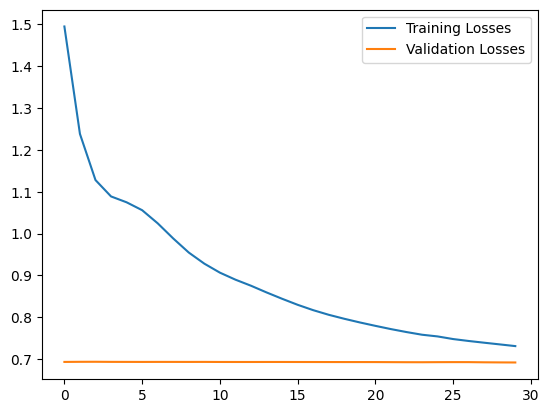

In [378]:
fig, ax = plt.subplots()

ax = sns.lineplot(train_losses, label='Training Losses')
ax = sns.lineplot(val_losses, label='Validation Losses')

plt.show()

Evaluate

In [379]:
salads = glob('../SaladWithPizza/test/Salad/*')
pizzas = glob('../SaladWithPizza/test/pizza/*')
class_names = train_folder.classes
results = {}

for a, b in zip(salads, pizzas):
    _, a_tensor = PreProssor.process_image(a)
    _, b_tensor = PreProssor.process_image(b)

    results[a] = [nnlib.predict(model, a_tensor, device, class_names), 'Salad']
    results[b] = [nnlib.predict(model, b_tensor, device, class_names), 'pizza']

keys = [str(key).split('\\')[1] for key in results.keys()]
pred_values = [result[0] for result in results.values()]
real_values = [result[1] for result in results.values()]

results_df = pd.DataFrame({"ID":keys, "Predict":pred_values, "Real":real_values})
results_df[['Predict', 'Real']].value_counts()

Predict  Real 
Salad    Salad    10
         pizza    10
Name: count, dtype: int64

Kappa:0.00 |  Recall:1.00 |  F1:0.67 |  Precision:0.50


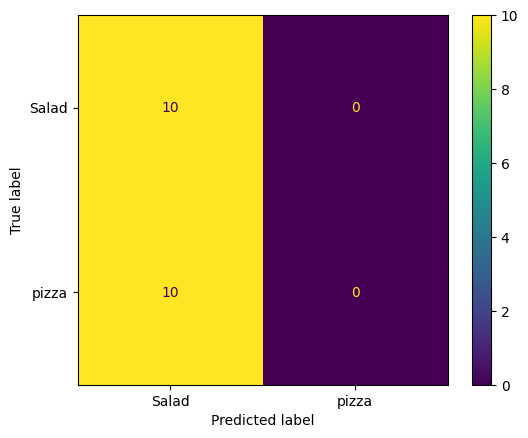

In [380]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score, recall_score, f1_score, precision_score

matrix = confusion_matrix(y_true=results_df['Real'], y_pred=results_df['Predict'])
kappa = cohen_kappa_score(y1=results_df['Predict'], y2=results_df['Real'])
recall = recall_score(y_true=results_df['Real'], y_pred=results_df['Predict'], pos_label='Salad')
f1 = f1_score(y_pred=results_df['Predict'], y_true=results_df['Real'], pos_label='Salad')
precision = precision_score(y_pred=results_df['Predict'], y_true=results_df['Real'], pos_label='Salad')

print(f"Kappa:{kappa:.2f} |  Recall:{recall:.2f} |  F1:{f1:.2f} |  Precision:{precision:.2f}")

disp = ConfusionMatrixDisplay(matrix, display_labels=class_names)
disp.plot()
plt.show()

In [381]:
model_name = model._get_name()
parameters = [[[name, pram.size()] for name, pram in model.named_parameters()]]
total_epochs = model.total_epochs

output = pd.DataFrame({"Name":model_name + '-SVP', "kappa":kappa, "recall":recall, "f1":f1, "precision":precision, "epochs":total_epochs, "Parameters":parameters}, index=range(1, 2))
output

,Name,kappa,recall,f1,precision,epochs,Parameters
1,MemeClassConv2d-SVP,0.0,1.0,0.666667,0.5,30,"[[conv1.weight, (6, 3, 5, 5)], [conv1.bias, (6..."


In [382]:
# path = "../models/"
model_name = f"{model._get_name()}_V2"

save = True
if save is True:
    try:
        output_csv = pd.read_csv('../models/modelstransfer.csv')
        output = pd.concat([output_csv, output])
        output.to_csv('../models/modelstransfer.csv', index=False)
        # torch.save(model, f"../models/{model_name}")

    except:
        output.to_csv('../models/modelstransfer.csv', index=False)
